Most of the code is from [Tutorial from Depends on The Definition](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/) but modified for this final project task and domain.

# Setup and Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%notebook inline

In [3]:
ROOT_PATH = '/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/';

In [4]:
!pip install transformers

In [5]:
!pip install seqeval

In [6]:
import pandas as pd 
import numpy as np
import json
from transformers import BertTokenizer, BertConfig, XLMRobertaTokenizer, XLMRobertaConfig, DistilBertTokenizer, DistilBertConfig
from transformers import BertForTokenClassification, XLMRobertaForTokenClassification, DistilBertForTokenClassification

In [7]:
model_type = "distilbert"
FINE_TUNING_TYPE = "full"
VERSION = 2
SCENARIO = 1
EPOCH_CONST = 25
BATCH_SIZE = 8
WEIGHT_DECAY_RATE = 0.01
TRAINING_SIZE = None
TESTING_SIZE = None

In [8]:
experiment_information = model_type + "_v" + str(VERSION)
if FINE_TUNING_TYPE == "full" :
  experiment_information += "_full"
elif FINE_TUNING_TYPE == "partial" :
  experiment_information += "_partial"

print ("Info", experiment_information)

training_filename = "scenario-" + str(SCENARIO) + "-train.json"
testing_filename = "scenario-" + str(SCENARIO) + "-test.json"

MODEL_PATH = ROOT_PATH + "model/scenario " + str(SCENARIO) + '/'
RESULT_PATH = ROOT_PATH + "result/scenario " + str(SCENARIO) + '/'
DATASET_PATH = ROOT_PATH + "dataset/version " + str(VERSION) + '/'

print (MODEL_PATH)
print (RESULT_PATH)
print (DATASET_PATH)

Info distilbert_v2_full
/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/model/scenario 1/
/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/result/scenario 1/
/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/dataset/version 2/


# Dataset

In [9]:
def readJSON(filename) :
  with open(filename, 'r', encoding="utf8") as f:
    obj = json.load(f)
  return obj

def writeJSON(obj, filename) :
  with open(filename, 'w', encoding="utf8") as outfile:
    json.dump(obj, outfile)
  print ("Successfully write JSON obj to", filename)

In [10]:
LIMIT_SIZE = 5

In [11]:
training_data = readJSON(DATASET_PATH + training_filename)
print (training_data['tokens_labels'][0][0:LIMIT_SIZE])

testing_data = readJSON(DATASET_PATH + testing_filename)
print (testing_data['tokens_labels'][0][0:LIMIT_SIZE])

[{'token': 'Emina', 'label': '1-B-Merek'}, {'token': 'Beauty', 'label': '3-B-NamaProduk'}, {'token': 'Bliss', 'label': '3-I-NamaProduk'}, {'token': 'Bb', 'label': '3-I-NamaProduk'}, {'token': 'Cream', 'label': '3-I-NamaProduk'}]
[{'token': 'Wardah', 'label': '1-B-Merek'}, {'token': 'Everyday', 'label': '3-B-NamaProduk'}, {'token': 'Cheek', 'label': '3-I-NamaProduk'}, {'token': '&', 'label': '3-I-NamaProduk'}, {'token': 'Liptint', 'label': '3-I-NamaProduk'}]


In [12]:
training_labels = [[object['label'] for object in objects] for objects in training_data["tokens_labels"]]
print (training_labels[0][0:LIMIT_SIZE])
training_sentences = [[object['token'] for object in objects] for objects in training_data["tokens_labels"]]
print (training_sentences[0][0:LIMIT_SIZE])

if TRAINING_SIZE :
  training_labels = training_labels[:TRAINING_SIZE]
  training_sentences = training_sentences[:TRAINING_SIZE]
print ("Jumlah label", str(len(training_labels)), " Jumlah kalimat", str(len(training_sentences)))

['1-B-Merek', '3-B-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk']
['Emina', 'Beauty', 'Bliss', 'Bb', 'Cream']
Jumlah label 1278  Jumlah kalimat 1278


In [13]:
testing_labels = [[object['label'] for object in objects] for objects in testing_data["tokens_labels"]]
print (testing_labels[0][0:LIMIT_SIZE])
testing_sentences = [[object['token'] for object in objects] for objects in testing_data["tokens_labels"]]
print (testing_sentences[0][0:LIMIT_SIZE])

if TESTING_SIZE :
  testing_labels = testing_labels[:TESTING_SIZE]
  testing_sentences = testing_sentences[:TESTING_SIZE]
print ("Jumlah label", str(len(testing_labels)), " Jumlah kalimat", str(len(testing_sentences)))

['1-B-Merek', '3-B-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk']
['Wardah', 'Everyday', 'Cheek', '&', 'Liptint']
Jumlah label 129  Jumlah kalimat 129


In [14]:
tag2idx = {
    "1-B-Merek" : 1,
    "1-I-Merek" : 2,
    "2-O" : 3,
    "3-B-NamaProduk" : 4,
    "3-I-NamaProduk" : 5,
    "4-B-Varian" : 6,
    "4-I-Varian" : 7,
    "5-B-Ukuran" : 8,
    "5-I-Ukuran" : 9,
    "6-B-Penggunaan" : 10,
    "6-I-Penggunaan" : 11,
    "7-B-Tekstur" : 12,
    "7-I-Tekstur" : 13,
    "PAD" : 14
}

tag2idx2= {
    "B-Merek" : 1,
    "I-Merek" : 2,
    "O" : 3,
    "B-NamaProduk" : 4,
    "I-NamaProduk" : 5,
    "B-Varian" : 6,
    "I-Varian" : 7,
    "B-Ukuran" : 8,
    "I-Ukuran" : 9,
    "B-Penggunaan" : 10,
    "I-Penggunaan" : 11,
    "B-Tekstur" : 12,
    "I-Tekstur" : 13,
    "PAD" : 14
}

tag_values = [tag for tag in tag2idx2.keys()]
print (tag_values)

['B-Merek', 'I-Merek', 'O', 'B-NamaProduk', 'I-NamaProduk', 'B-Varian', 'I-Varian', 'B-Ukuran', 'I-Ukuran', 'B-Penggunaan', 'I-Penggunaan', 'B-Tekstur', 'I-Tekstur', 'PAD']


In [15]:
if model_type == "xlmr" :
  MODEL_NAME = 'xlm-roberta-base'
  tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
  model = XLMRobertaForTokenClassification.from_pretrained(
      MODEL_NAME,
      num_labels=len(tag2idx),
      output_attentions = False,
      output_hidden_states = False
  )

elif model_type == "mbert" :
  MODEL_NAME = 'bert-base-multilingual-cased'
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
  model = BertForTokenClassification.from_pretrained(
      MODEL_NAME,
      num_labels=len(tag2idx),
      output_attentions = False,
      output_hidden_states = False
  )

elif model_type == "distilbert" :
  MODEL_NAME = 'distilbert-base-multilingual-cased'
  tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
  model = DistilBertForTokenClassification.from_pretrained(
      MODEL_NAME,
      num_labels=len(tag2idx),
      output_attentions = False,
      output_hidden_states = False
  )

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You s

In [16]:
params = list(model.named_parameters())

print('The {:} model has {:} different named parameters.\n'.format(model_type, len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The distilbert model has 102 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (119547, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight     

In [17]:
no_decay = ['bias', 'gamma', 'beta']
last_layer = ['classifier.weight']

# Training Setup

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.6.0+cu101'

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [20]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [21]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [22]:
MAX_LEN = max(max([len(training_sentence) for training_sentence in training_sentences]), max([len(testing_sentence) for testing_sentence in testing_sentences]))
print ("Token length", MAX_LEN, " Batch size", BATCH_SIZE)

Token length 312  Batch size 8


In [23]:
training_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(training_sentences, training_labels)
]

training_tokenized_texts = [token_label_pair[0] for token_label_pair in training_tokenized_texts_and_labels]
training_labels = [token_label_pair[1] for token_label_pair in training_tokenized_texts_and_labels]

training_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in training_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

training_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in training_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

training_attention_masks = [[float(i != 0.0) for i in ii] for ii in training_input_ids]

In [24]:
testing_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(testing_sentences, testing_labels)
]

testing_tokenized_texts = [token_label_pair[0] for token_label_pair in testing_tokenized_texts_and_labels]
testing_labels = [token_label_pair[1] for token_label_pair in testing_tokenized_texts_and_labels]

testing_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in testing_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

testing_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in testing_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

testing_attention_masks = [[float(i != 0.0) for i in ii] for ii in testing_input_ids]

In [25]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(training_input_ids, training_tags,
                                                            random_state=2020, test_size=0.3)
tr_masks, val_masks, _, _ = train_test_split(training_attention_masks, training_input_ids,
                                             random_state=2020, test_size=0.3)

In [26]:
tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)

test_inputs = torch.tensor(testing_input_ids)
test_tags = torch.tensor(testing_tags)
test_masks = torch.tensor(testing_attention_masks)

In [27]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

# Training

In [28]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.0.2'

In [29]:
model.cuda();

In [30]:
if FINE_TUNING_TYPE == "full" :
  param_optimizer = list(model.named_parameters())
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': WEIGHT_DECAY_RATE},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
  ]
elif FINE_TUNING_TYPE == "partial":
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in last_layer)],
       'weight_decay_rate': 0.0},
      {'params': [torch.tensor(0) for n, p in param_optimizer if any(nd in n for nd in last_layer)],
       'weight_decay_rate': WEIGHT_DECAY_RATE}
  ]
else :
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

print (FINE_TUNING_TYPE)

full


In [31]:
from transformers import get_linear_schedule_with_warmup
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCH_CONST

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [32]:
from seqeval.metrics import f1_score, accuracy_score
from seqeval.metrics import classification_report

In [33]:
loss_values, validation_loss_values, validation_accuracies, validation_f1scores = [], [], [], []

for _ in range(EPOCH_CONST):
    model.train()
    total_loss = 0

    # Training
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]

        loss.backward()
        total_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)

    # Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                for p_i, l_i in zip(p, l) if tag_values[l_i - 1] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i - 1] != "PAD"]
    
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    validation_accuracies.append(accuracy_score(valid_tags, pred_tags))
    
    print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
    validation_f1scores.append(f1_score(valid_tags, pred_tags))
    
    print (classification_report(valid_tags, pred_tags))
    print()

Average train loss: 0.5154704003195677
Validation loss: 0.18171548626075187
Validation Accuracy: 0.9480437762646352
Validation F1-Score: 0.9476785265200052
            precision    recall  f1-score   support

    Varian       0.84      0.83      0.84      3816
NamaProduk       0.96      0.98      0.97     34599
Penggunaan       0.84      0.85      0.85       652
     Merek       0.90      0.95      0.92       762
    Ukuran       0.80      0.66      0.72      1702
   Tekstur       0.00      0.00      0.00        68
       PAD       0.00      0.00      0.00         5

 micro avg       0.94      0.95      0.95     41604
 macro avg       0.94      0.95      0.95     41604


Average train loss: 0.14860420301556587
Validation loss: 0.15097935218364
Validation Accuracy: 0.9547180835524394
Validation F1-Score: 0.9554250505439491
            precision    recall  f1-score   support

    Varian       0.84      0.87      0.86      3816
NamaProduk       0.98      0.97      0.98     34599
Penggunaa

In [34]:
import datetime
torch.save(model, MODEL_PATH + experiment_information + ".pth")
# torch.save(model, MODEL_PATH + experiment_information + "-" + str(datetime.datetime.now().time()) + ".pth")

In [35]:
metrics = {}
metrics_training = {}
metrics_training['loss-values'] = loss_values
metrics_training['validation-loss'] = validation_loss_values
metrics_training['validation-accuracy'] = validation_accuracies
metrics_training['validation-f1'] = validation_f1scores
metrics_training['classification_report'] = classification_report(valid_tags, pred_tags)

metrics['training'] = metrics_training

for key, values in metrics.items() :
  print (key, len(values))

training 5


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


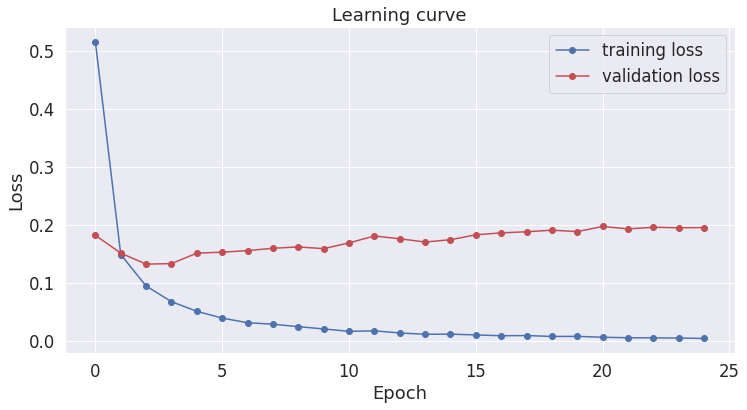

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [37]:
model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

eval_loss = eval_loss / len(test_dataloader)
validation_loss_values.append(eval_loss)
print("Validation loss: {}".format(eval_loss))

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                            for p_i, l_i in zip(p, l) if tag_values[l_i - 1] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i - 1] != "PAD"]

print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
validation_accuracies.append(accuracy_score(valid_tags, pred_tags))

print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
validation_f1scores.append(f1_score(valid_tags, pred_tags))

print (classification_report(valid_tags, pred_tags))
print()

print (pred_tags[0:LIMIT_SIZE])

print (valid_tags[0:LIMIT_SIZE])

Validation loss: 0.10142756735577303
Validation Accuracy: 0.9851824274013403
Validation F1-Score: 0.9851908954436647
            precision    recall  f1-score   support

NamaProduk       0.99      0.99      0.99     10155
     Merek       0.98      1.00      0.99       164
Penggunaan       0.97      0.93      0.95       321
    Varian       0.95      0.96      0.95      1213
    Ukuran       0.91      0.92      0.92       407
   Tekstur       0.92      0.80      0.85        59
       PAD       1.00      1.00      1.00         1

 micro avg       0.98      0.99      0.99     12320
 macro avg       0.98      0.99      0.99     12320


['I-Merek', 'I-Merek', 'I-NamaProduk', 'I-NamaProduk', 'B-Varian']
['I-Merek', 'I-Merek', 'I-NamaProduk', 'I-NamaProduk', 'B-Varian']


In [38]:
metrics_testing = {}
metrics_testing['loss-values'] = loss_values
metrics_testing['validation-loss'] = validation_loss_values
metrics_testing['validation-accuracy'] = validation_accuracies
metrics_testing['validation-f1'] = validation_f1scores
metrics_testing['classification_report'] = classification_report(valid_tags, pred_tags)

metrics['testing'] = metrics_testing

In [39]:
writeJSON(metrics, RESULT_PATH + experiment_information + ".json")
# writeJSON(metrics, RESULT_PATH + experiment_information + "-" + str(datetime.datetime.now().time()) + ".json")

Successfully write JSON obj to /content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/result/scenario 1/distilbert_v2_full.json
